## Try Polars
This notebook is just for learning polars

# import libraries

In [1]:
import os
import gc
import pickle
import glob
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import time
import math
import sys

import polars as pl

import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier, Pool

import xgboost as xgb
import torch
import cupy 
import cudf
from cuml import ForestInference

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score
from sklearn.model_selection import GroupKFold
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

# Set Configurations

In [2]:
CFG = {
    "DEBUG" : False,
    "EXP_NAME" : "expCAT001",
    "n_folds" : 5,
    "train_folds" : [0,1,2,3,4],
    
}

CFG["cat_params"] = {
            'iterations': 10000,
            'learning_rate' : 0.01,
            'loss_function' : 'Logloss',
            'eval_metric' : 'AUC',
            'verbose' : 200,
            'random_seed' : 42,
            'use_best_model': True,
}


CFG["lgb_params"] = { 'boosting_type' :'dart',
                      'objective': 'binary',
                      'random_state': 21,
                      'learning_rate': 0.01,
                      'n_estimators':5000,
                      }

# CFG["xgb_params"] =  {
#                         'objective': 'binary:logistic',
#                         'eval_metric': 'auc',
#                         'learning_rate':0.01,
#                         'tree_method':'hist' if not torch.cuda.is_available() else 'gpu_hist',
#                         'seed': 42,
#                     }

if CFG["DEBUG"]:
    CFG["EXP_CATEGORY"] = "DEBUG"
    CFG["sample_num"] = 1000

CFG["INPUT_DIR"] = "/workspace/input"
CFG["OUTPUT_DIR"] = "/workspace/output"
CFG["BASE_DIR"] = os.path.join(CFG["INPUT_DIR"])
CFG["TRAIN_HELMET_CSV"] = os.path.join(CFG["BASE_DIR"], "train_baseline_helmets.csv")
CFG["TRAIN_TRACKING_CSV"] = os.path.join(CFG["BASE_DIR"], "train_player_tracking.csv")
CFG["TRAIN_VIDEO_META_CSV"] = os.path.join(CFG["BASE_DIR"], "train_video_metadata.csv")
CFG["TRAIN_LABEL_CSV"] = os.path.join(CFG["BASE_DIR"], "train_labels.csv")

CFG["NN_FEATURE_CSV_1"] = os.path.join(CFG["OUTPUT_DIR"], "expP011_PandG_bothview_swins3base224", "oof_df.csv")
CFG["NN_FEATURE_CSV_2"] = os.path.join(CFG["OUTPUT_DIR"], "expP014_PandG_nomask_swins3base224", "oof_df.csv")
CFG["NN_FEATURE_CSV_3"] = os.path.join(CFG["OUTPUT_DIR"], "expP015_PandG_nomaskzoom_swins3base224", "oof_df.csv")

CFG["TRACK_FEATURE_CSV"] = os.path.join(CFG["OUTPUT_DIR"], "expT010_Trackshift1D", "oof_df.csv")

CFG["TEST_HELMET_CSV"] = os.path.join(CFG["BASE_DIR"], "test_baseline_helmets.csv")
CFG["TEST_TRACKING_CSV"] = os.path.join(CFG["BASE_DIR"], "test_player_tracking.csv")
CFG["TEST_VIDEO_META_CSV"] = os.path.join(CFG["BASE_DIR"], "test_video_metadata.csv")
CFG["TEST_LABEL_CSV"] = os.path.join(CFG["BASE_DIR"], "sample_submission.csv")


CFG["EXP_DIR"] = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"])
if not CFG["DEBUG"]:
    os.mkdir(CFG["EXP_DIR"])

# MODEL Functions

In [3]:
def fit_lgboost(df_, feature_cols_):
    kf = GroupKFold(n_splits=CFG["n_folds"])
    X = df_[feature_cols_]
    y = df_["contact"]
    oof_pred = np.zeros(len(y), dtype=np.float32)
    generator = kf.split(X, y, df_["game_play"])
    for fold, (idx_train, idx_valid) in enumerate(generator):
        print("-")
        print(f"fold {fold}")
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        display(pd.Series(y_valid).value_counts())

        params = CFG["lgb_params"]
        model = LGBMClassifier(**params).fit(x_train, y_train, 
                                   eval_set=[(x_train, y_train), (x_valid, y_valid)],
                                   callbacks=[early_stopping(200), log_evaluation(100)],
                                   eval_metric=['auc'],)

        model_path = os.path.join(CFG["EXP_DIR"], f'lgb_fold{fold}.model')
        pickle.dump(model, open(model_path, 'wb'))
        importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
        display(importance.sort_values("importance", ascending=False).head(20))

        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()

    oof_pred_file = os.path.join(CFG["EXP_DIR"], 'oof_pred')
    df_["pred"] = oof_pred
    np.save(oof_pred_file, oof_pred)
    auc = round(roc_auc_score(y, oof_pred), 5)
    
    def func(x_list):
        score = matthews_corrcoef(df_['contact'], df_["pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(df_['contact'], df_["pred"]>opt_threshold), 5)
    
    print(f'All Performance of the AUC:{auc}, MCC:{score}')
    return oof_pred


In [4]:
def fit_catboost(df_, feature_cols_):
    kf = GroupKFold(n_splits=CFG["n_folds"])
    X = df_[feature_cols_]
    y = df_["contact"]
    oof_pred = np.zeros(len(y), dtype=np.float32)
    generator = kf.split(X, y, df_["game_play"])
    for fold, (idx_train, idx_valid) in enumerate(generator):
        print("-")
        print(f"fold {fold}")
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        display(pd.Series(y_valid).value_counts())

        params = CFG["cat_params"]
        model =  CatBoostClassifier(**params)
        model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=100, early_stopping_rounds=200)
        model_path = os.path.join(CFG["EXP_DIR"], f'cat_fold{fold}.model')
        pickle.dump(model, open(model_path, 'wb'))
        importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
        display(importance.sort_values("importance", ascending=False).head(20))

        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()
    
    oof_pred_file = os.path.join(CFG["EXP_DIR"], 'oof_pred')
    df_["pred"] = oof_pred
    np.save(oof_pred_file, oof_pred)
    auc = round(roc_auc_score(y, oof_pred), 5)
    
    def func(x_list):
        score = matthews_corrcoef(df_['contact'], df_["pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(df_['contact'], df_["pred"]>opt_threshold), 5)
    
    print(f'All Performance of the AUC:{auc}, MCC:{score}')
    return oof_pred

In [5]:
def fit_xgboost(df_, feature_cols_):
    kf = GroupKFold(n_splits=CFG["n_folds"])
    X = df_[feature_cols_]
    y = df_["contact"]
    oof_pred = np.zeros(len(y), dtype=np.float32)
    generator = kf.split(X, y, df_["game_play"])
    for fold, (idx_train, idx_valid) in enumerate(generator):
        print("-")
        print(f"fold {fold}")
        # set dataset
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        display(pd.Series(y_valid).value_counts())
        xgb_train = xgb.DMatrix(x_train, label=y_train)
        xgb_valid = xgb.DMatrix(x_valid, label=y_valid)
        evals = [(xgb_train,'train'),(xgb_valid,'eval')]
        # fit
        params = CFG["xgb_params"]
        model = xgb.train(
            params,
            xgb_train,
            num_boost_round=10_000,
            early_stopping_rounds=200,
            evals=evals,
            verbose_eval=100,
        )

        model_path = os.path.join(CFG["EXP_DIR"], f'xgb_fold{fold}.model')
        model.save_model(model_path)
        _, ax = plt.subplots(figsize=(20, 16))
        xgb.plot_importance(model,
                            ax=ax,
                            importance_type='gain',
                            show_values=False)
        plt.show()

        if not torch.cuda.is_available():
            model = xgb.Booster().load_model(model_path)
        else:
            model = ForestInference.load(model_path, output_class=True, model_type='xgboost')
        
        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()
    
    oof_pred_file = os.path.join(CFG["EXP_DIR"], 'oof_pred')
    df_["pred"] = oof_pred
    np.save(oof_pred_file, oof_pred)
    auc = round(roc_auc_score(y, oof_pred), 5)
    
    def func(x_list):
        score = matthews_corrcoef(df_['contact'], df_["pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(df_['contact'], df_["pred"]>opt_threshold), 5)
    
    print(f'All Performance of the AUC:{auc}, MCC:{score}')
    return oof_pred

# Dataset Functions

In [6]:
def add_feature_cols(df_, feature_cols_, remove_col_list):
    additional_cols = list(df_.columns)
    additional_cols = [col for col in additional_cols if not col in remove_col_list]
    feature_cols_.extend(additional_cols)
    return feature_cols_

## Merge Functions

In [7]:
def target_merge_tracking(target_df_, tracking_df_, feature_cols_, SHIFT_COLS_):
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("step").cast(str),
                                                     pl.col("nfl_player_id_1"),
                                                    ], sep='_').alias('game_step_player_1'))
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("step").cast(str),
                                                     pl.col("nfl_player_id_2"),
                                                    ], sep='_').alias('game_step_player_2'))
    # line man positions
    lineman_pos = ["T", "G", "C", "DE", "DT", "NG"]
    tracking_df_ = tracking_df_.with_column((pl.col("position").is_in(lineman_pos)).cast(int).alias('is_lineman'))
    
    
    # Norm cols
    norm_cols = ["x_position", "y_position", "direction", "orientation"]
    Norm_value_list = [120., 60., 360., 360.]
    for col, norm_val in zip(norm_cols, Norm_value_list):
        tracking_df_ = tracking_df_.with_column((pl.col(col)/norm_val).alias(col))
    
    # use columns
    track_cols = ["game_play", "nfl_player_id", "step", 
                   "x_position", "y_position", "datetime",
                   "speed","distance","direction","orientation",
                   "acceleration","sa", "team", "jersey_number",
                   "is_lineman",
                 ]
    track_cols.extend(SHIFT_COLS_)
    tracking_df_ = tracking_df_.select(track_cols)
    tracking_df_ = tracking_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                         pl.col("step").cast(str),
                                                         pl.col("nfl_player_id"),
                                                        ], sep='_').alias('game_step_player'))

    tracking_df_ = tracking_df_.drop(["game_play", "step", "nfl_player_id", "datetime"])

    # merge tracking to target
    for player_id in [1,2]:
        tracking_player = tracking_df_.select([pl.all().suffix(f"_{player_id}")])
        target_df_ = target_df_.join(tracking_player, on=[f"game_step_player_{player_id}"], how="left")
        # add features col
        feature_cols_ = add_feature_cols(tracking_player, feature_cols_,
                                        [f"game_step_player_{player_id}", f"frame_{player_id}", f"datetime_{player_id}"])
    # drop col
    target_df_ = target_df_.drop(["game_step_player_1", "game_step_player_2"])
    print(len(target_df_.columns))
    print("original length", len(target_df_))
    return target_df_, feature_cols_

In [8]:
def target_merge_helmet(target_df_, helmet_df_, feature_cols_):
    print("original length", len(target_df_))
    # set merge-key (game_frame_player_1,2) to merge helmet_df
    target_df_ = target_df_.with_column(((pl.col("step").cast(int)/10*59.94+5*59.94).cast(int)+1).alias("frame"))
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id_1"),
                                                    ], sep='_').alias('game_frame_player_1'))
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id_2"),
                                                    ], sep='_').alias('game_frame_player_2'))
    # set merge key
    helmet_df_ = helmet_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id"),
                                                    ], sep='_').alias('game_frame_player'))

    # merge target df & helmet_df
    player_views = [[1, "Endzone"],[2, "Endzone"], [1, "Sideline"],[2, "Sideline"]]
    for player_id, view in player_views:
        helmet_view = helmet_df_.filter(pl.col("view")==view)
        helmet_view = helmet_view[["game_frame_player", "left", "width", "top", "height"]]
        helmet_view = helmet_view.select(pl.all().suffix(f"_{player_id}"))
        helmet_view = helmet_view.select([pl.col(helmet_view.columns[0]), pl.col(helmet_view.columns[1:]).prefix(f"{view[0]}_")])
        target_df_ = target_df_.join(helmet_view, on=f"game_frame_player_{player_id}", how="left")  
        # add features col
        feature_cols_ = add_feature_cols(helmet_view, feature_cols_, [f"game_frame_player_{player_id}"])

    print(len(target_df_.columns))
    print("original length", len(target_df_))
    return target_df_, feature_cols_

## Create feature function

In [9]:
def get_tracking_shift(tracking_df_, shift_cols=["x_position","y_position"], shift_nums=range(-6,6,1)):
    # get shift key
    tracking_df_ = tracking_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                         pl.col("nfl_player_id"),
                                                        ], sep='_').alias('shift_key'))
    # get shift features
    shift_col_list = []
    for num in shift_nums:
        tracking_df_ = tracking_df_.with_columns(
                            pl.col(shift_cols).shift(periods=num).over("shift_key").suffix(f"_shift{num}"))
    for col in shift_cols:
        colname = [f"{col}_shift{idx}" for idx in shift_nums]
        shift_col_list.extend(colname)
                    
    return tracking_df_, shift_col_list

In [10]:
def create_trackmerged_ftr(target_df_, feature_cols_,
                           diff_cols = ['x_position', 'y_position', 'speed', 'distance',
                                        'direction', 'orientation', 'acceleration', 'sa']):    
#     target_df_ = target_df_.with_column((np.sqrt(np.square(pl.col("x_position_1")-pl.col("x_position_2")) \
#                                               + np.square(pl.col("y_position_1")-pl.col("y_position_2"))) \
#                                       ).alias("players_dis"))
    target_df_ = target_df_.with_column((np.sqrt(np.square(pl.col("x_position_1")*120. - pl.col("x_position_2")*120.) \
                                              + np.square(pl.col("y_position_1")*60. - pl.col("y_position_2")*60.)) \
                                      ).alias("players_dis"))
    target_df_ = target_df_.with_column(pl.col("players_dis").fill_null(0))
    
    # players distance sum(in shift range time : default(-6~6 frames not step))
    players_distance_sum = 0
    for idx in range(-6,6,1):
        players_distance_sum += np.sqrt((target_df_[f"x_position_shift{idx}_1"] - target_df_[f"x_position_shift{idx}_2"])**2 \
                                       + (target_df_[f"y_position_shift{idx}_1"] - target_df_[f"y_position_shift{idx}_2"])**2)
    target_df_ = target_df_.with_column(pl.Series("players_distance_sum", players_distance_sum))
    target_df_ = target_df_.with_column(pl.col("players_distance_sum").fill_null(0))
    feature_cols_.append("players_distance_sum")

    # players each axis distance sum(in shift range time : default(-6~6 frames not step))
    for axis in ["x", "y"]:
        axis_distance_1 = 0
        axis_distance_2 = 0
        for idx in range(-6, 5, 1):
            axis_distance_1 += abs(target_df_[f"{axis}_position_shift{idx}_1"] - target_df_[f"{axis}_position_shift{idx+1}_1"])
            axis_distance_2 += abs(target_df_[f"{axis}_position_shift{idx}_2"] - target_df_[f"{axis}_position_shift{idx+1}_2"])
        target_df_ = target_df_.with_column(pl.Series(f"{axis}_move_distance_1", axis_distance_1))
        target_df_ = target_df_.with_column(pl.col(f"{axis}_move_distance_1").fill_null(0))
        target_df_ = target_df_.with_column(pl.Series(f"{axis}_move_distance_2", axis_distance_2))
        target_df_ = target_df_.with_column(pl.col(f"{axis}_move_distance_2").fill_null(0))
        feature_cols_.extend([f"{axis}_move_distance_1", f"{axis}_move_distance_2"])

    # players difference ftr (in each step)
    for col in diff_cols:
        colname = f"{col}_diff"
        target_df_ = target_df_.with_column((abs(pl.col(f"{col}_1") - pl.col(f"{col}_2"))).alias(colname))
        target_df_ = target_df_.with_column(pl.col(colname).fill_null(0))
        feature_cols_.append(colname)
        
    return target_df_, feature_cols_

In [11]:
def create_roll_ftr(target_df_, feature_cols_,
                    roll_cols = ['players_dis', 'x_position_diff', 'y_position_diff', 
                                  'speed_diff', 'distance_diff','direction_diff',
                                  'orientation_diff', 'acceleration_diff', 'sa_diff'],
                    key_cols = ["contact_id", "game_play", "nfl_player_id_1", 
                                "nfl_player_id_2", "step"]):
    roll_df = target_df_.select(roll_cols+key_cols)

    roll_df = roll_df.with_column(pl.concat_str([pl.col("game_play"),
                                                 pl.col("nfl_player_id_1"),
                                                 pl.col("nfl_player_id_2"),
                                                ], sep='_').alias('key'))
    # cast datetime

    # groupby rolling
    roll_df = roll_df.groupby_dynamic("step", every="1i", period="6i", by="key", closed="both").agg([pl.col(roll_cols).sum().suffix("_rollsum"), pl.col("contact_id")])
    roll_df = roll_df.with_column(pl.col("contact_id").apply(lambda x:x[0]))
    roll_df = roll_df.drop(["key", "step"])
    target_df_ = target_df_.join(roll_df, on="contact_id", how="left")
    additional_cols = [col+"_rollsum" for col in roll_cols]
    feature_cols_.extend(additional_cols)
    return target_df_, feature_cols_

In [12]:
def create_helmetmerged_ftr(target_df_, feature_cols_):
    # helmet center distance feature
    for view in ["Endzone", "Sideline"]:
        for p_id in ["1", "2"]: 
            # get helmet center
            target_df_ = target_df_.with_column((pl.col(f"{view[0]}_left_{p_id}") + (pl.col(f"{view[0]}_width_{p_id}")//2)).alias(f"{view[0]}_Wcenter_{p_id}"))
            target_df_ = target_df_.with_column((pl.col(f"{view[0]}_top_{p_id}") + (pl.col(f"{view[0]}_height_{p_id}")//2)).alias(f"{view[0]}_Hcenter_{p_id}"))
        # helmet center distance
        target_df_ = target_df_.with_column((np.sqrt(np.square(pl.col(f"{view[0]}_Wcenter_1") - pl.col(f"{view[0]}_Wcenter_2")) \
                                                  + np.square(pl.col(f"{view[0]}_Hcenter_1") - pl.col(f"{view[0]}_Hcenter_2")))
                                          ).alias(f"{view[0]}_helmet_dis"))

        # GがNanになるので0にしておく
        target_df_ = target_df_.with_column(pl.col(f"{view[0]}_helmet_dis").fill_null(0))
        feature_cols_.append(f"{view[0]}_helmet_dis")
    
    # helmet cols fillna(0) after get helmet distance 
    helmet_cols = ['E_left_1', 'E_width_1', 'E_top_1', 'E_height_1',
                   'E_left_2', 'E_width_2', 'E_top_2', 'E_height_2', 
                   'S_left_1','S_width_1', 'S_top_1', 'S_height_1', 
                   'S_left_2', 'S_width_2', 'S_top_2', 'S_height_2']
    target_df_ = target_df_.with_column(pl.col(helmet_cols).fill_null(0))

    return target_df_, feature_cols_

In [13]:
def get_categorical_ftr(target_df_, feature_cols_):
    target_df_ = target_df_.with_column((pl.col("nfl_player_id_2")== "G").cast(int).alias("is_ground"))
    # set team 
    target_df_ = target_df_.with_column(((pl.col("team_1")=="home").cast(int)).alias("team_1"))
    target_df_ = target_df_.with_column(((pl.col("team_2")=="home").cast(int)).alias("team_2"))
    target_df_ = target_df_.with_column(pl.col('nfl_player_id_2').str.replace("G", "99999"))
    
    target_df_ = target_df_.with_column((1 - ((pl.col("E_width_1")==0) & (pl.col("E_width_2")==0)).cast(int)).alias("is_E_helmet"))
    target_df_ = target_df_.with_column((1 - ((pl.col("S_width_1")==0) & (pl.col("S_width_2")==0)).cast(int)).alias("is_S_helmet"))
    target_df_ = target_df_.with_column(((pl.col("is_E_helmet")==1) & (pl.col("is_S_helmet")==1)).cast(int).alias("both_helmet"))
    
    target_df_ = target_df_.with_column(pl.col(["nfl_player_id_1", "nfl_player_id_2"]).cast(int))
    
    target_df_ = target_df_.fill_null(0)
    target_df_ = target_df_.fill_nan(0)
    feature_cols_.extend(["is_ground","is_E_helmet", "is_S_helmet", "both_helmet"])
    return target_df_, feature_cols_

# Merge NN df

In [15]:
def target_merge_emb(target_df_, nn_df_, feature_cols, view_, model_num, fillna_num=0):
    use_cols = ["contact_id"]
    cnn_ftr_list_ = [f"img_emb_{idx}" for idx in range(5)]
    cnn_ftr_list_.append("pred")
    use_cols.extend(cnn_ftr_list_)
    # set use cols
    nn_df_ = nn_df_.select(use_cols)
    nn_df_ = nn_df_.with_columns(pl.col(cnn_ftr_list_).prefix(f"m{model_num}_{view[0]}_"))
    target_df_ = target_df_.join(nn_df_, on="contact_id", how="left")
    target_df_ = target_df_.fill_null(fillna_num)
    target_df_ = target_df_.fill_nan(fillna_num)
    # add feature cols
    prefix_cnnftr_list_ = [f"m{model_num}_{view[0]}_img_emb_{idx}" for idx in range(5)]
    prefix_cnnftr_list_.append(f"m{model_num}_{view[0]}_pred")
    feature_cols.extend(prefix_cnnftr_list_)
    target_df_ = target_df_.drop(cnn_ftr_list_)
    return target_df_, feature_cols

In [16]:
def target_merge_trackemb(target_df_, nn_df_, feature_cols, fillna_num=0):
    use_cols = ["contact_id"]
    ftr_list_ = [f"track_emb_{idx}" for idx in range(3)]
    use_cols.extend(ftr_list_)
    # set use cols
    nn_df_ = nn_df_.select(use_cols)
    target_df_ = target_df_.join(nn_df_, on="contact_id", how="left")
    target_df_ = target_df_.fill_null(fillna_num)
    target_df_ = target_df_.fill_nan(fillna_num)
    # add feature cols
    ftr_list_ = [f"track_emb_{idx}" for idx in range(3)]
    feature_cols.extend(ftr_list_)
    return target_df_, feature_cols

# Post Proc

In [17]:
def post_proc_roll(sub_, target_df_, window_size_):
    sub_ = pd.merge(sub_, target_df_[["contact_id", "pred"]], on="contact_id", how="left")
    sub_ = sub_.fillna(0)
    proc_df = sub_.copy()
    proc_cols = ["contact_id", "game_play", "nfl_player_id_1", "nfl_player_id_2","step", "pred", "contact"]
    proc_df = proc_df[proc_cols]
    proc_df["proc_key"] = proc_df["game_play"] + "_" + proc_df["nfl_player_id_1"].astype("str") + "_" + proc_df["nfl_player_id_2"].astype("str")
    
    proc_pred = proc_df.groupby("proc_key")["pred"].rolling(window_size, center=True).mean().reset_index().set_index("level_1")
    proc_pred = proc_pred.rename(columns={"pred":"proc_pred"})    

    proc_df = pd.concat([proc_df, proc_pred], axis=1)
    proc_df["proc_pred"] = proc_df["proc_pred"].fillna(proc_df["pred"])
    return proc_df

---

# Load Target

In [18]:
target_dtypes = {'contact_id':str, 
                'game_play':str,
                'datetime':str,
                'step':int,
                'nfl_player_id_1':str,
                'nfl_player_id_2':str,
                'contact':int,
                }
target_df = pl.read_csv(CFG["TRAIN_LABEL_CSV"], dtypes=target_dtypes)    

FEATURE_COLS = ["nfl_player_id_1", "nfl_player_id_2", "step"]

# Merge tracking_df

In [19]:
tracking_df = pl.read_csv(CFG["TRAIN_TRACKING_CSV"])
tracking_df, SHIFT_COLS = get_tracking_shift(tracking_df)
target_df, FEATURE_COLS = target_merge_tracking(target_df, tracking_df, FEATURE_COLS, SHIFT_COLS)

del tracking_df

target_df, FEATURE_COLS = create_trackmerged_ftr(target_df, FEATURE_COLS)
target_df, FEATURE_COLS = create_roll_ftr(target_df, FEATURE_COLS)

77
original length 4721618


# Exclude distance > 2

In [20]:
target_df = target_df.filter(pl.col("players_dis") <= 2)
print(len(target_df))

660550


# Merge helmet df

In [21]:
helmet_df = pl.read_csv(CFG["TRAIN_HELMET_CSV"])
target_df, FEATURE_COLS = target_merge_helmet(target_df, helmet_df, FEATURE_COLS)
target_df, FEATURE_COLS = create_helmetmerged_ftr(target_df, FEATURE_COLS)
target_df, FEATURE_COLS = get_categorical_ftr(target_df, FEATURE_COLS)
print(len(target_df))

original length 660550
119
original length 660550
660550


# Merge NN feature

In [22]:
nn_df = pl.read_csv(CFG["NN_FEATURE_CSV_1"])

for view in ["Endzone", "Sideline"]:
    if view == "Endzone":
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 0)
    else:
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 0)
print(len(target_df))

660550


In [23]:
nn_df = pl.read_csv(CFG["NN_FEATURE_CSV_2"])

for view in ["Endzone", "Sideline"]:
    if view == "Endzone":
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 1)
    else:
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 1)
print(len(target_df))

660550


In [24]:
nn_df = pl.read_csv(CFG["NN_FEATURE_CSV_3"])

for view in ["Endzone", "Sideline"]:
    if view == "Endzone":
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 2)
    else:
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 2)
print(len(target_df))

660550


# Merge Track NN feature

In [25]:
tracknn_df = pl.read_csv(CFG["TRACK_FEATURE_CSV"])
target_df, FEATURE_COLS = target_merge_trackemb(target_df, tracknn_df, FEATURE_COLS)
print(len(target_df))

660550


In [26]:
# FEATURE_COLS = [col for col in FEATURE_COLS if not col in ["step"]]
print(FEATURE_COLS)

['nfl_player_id_1', 'nfl_player_id_2', 'step', 'x_position_1', 'y_position_1', 'speed_1', 'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1', 'team_1', 'jersey_number_1', 'is_lineman_1', 'x_position_shift-6_1', 'x_position_shift-5_1', 'x_position_shift-4_1', 'x_position_shift-3_1', 'x_position_shift-2_1', 'x_position_shift-1_1', 'x_position_shift0_1', 'x_position_shift1_1', 'x_position_shift2_1', 'x_position_shift3_1', 'x_position_shift4_1', 'x_position_shift5_1', 'y_position_shift-6_1', 'y_position_shift-5_1', 'y_position_shift-4_1', 'y_position_shift-3_1', 'y_position_shift-2_1', 'y_position_shift-1_1', 'y_position_shift0_1', 'y_position_shift1_1', 'y_position_shift2_1', 'y_position_shift3_1', 'y_position_shift4_1', 'y_position_shift5_1', 'x_position_2', 'y_position_2', 'speed_2', 'distance_2', 'direction_2', 'orientation_2', 'acceleration_2', 'sa_2', 'team_2', 'jersey_number_2', 'is_lineman_2', 'x_position_shift-6_2', 'x_position_shift-5_2', 'x_position_shift-4_2

# Train

In [27]:
target_df = target_df.to_pandas()
if CFG["DEBUG"]:
    target_df = target_df.sample(1000).reset_index(drop=True)
oof_pred = fit_catboost(target_df, FEATURE_COLS)
# oof_pred = fit_lgboost(target_df, FEATURE_COLS)
# oof_pred = fit_xgboost(target_df, FEATURE_COLS)

-
fold 0


0    119036
1     13030
Name: contact, dtype: int64

0:	test: 0.8786963	best: 0.8786963 (0)	total: 124ms	remaining: 20m 38s
100:	test: 0.9580496	best: 0.9580496 (100)	total: 5.21s	remaining: 8m 31s
200:	test: 0.9630106	best: 0.9630106 (200)	total: 10.3s	remaining: 8m 22s
300:	test: 0.9651345	best: 0.9651345 (300)	total: 15s	remaining: 8m 4s
400:	test: 0.9664459	best: 0.9664459 (400)	total: 19.6s	remaining: 7m 48s
500:	test: 0.9673181	best: 0.9673181 (500)	total: 24.6s	remaining: 7m 47s
600:	test: 0.9677947	best: 0.9677947 (600)	total: 29.9s	remaining: 7m 47s
700:	test: 0.9682877	best: 0.9682877 (700)	total: 34.9s	remaining: 7m 42s
800:	test: 0.9686743	best: 0.9686743 (800)	total: 39.9s	remaining: 7m 38s
900:	test: 0.9689276	best: 0.9689276 (900)	total: 45s	remaining: 7m 34s
1000:	test: 0.9691842	best: 0.9691842 (1000)	total: 50s	remaining: 7m 29s
1100:	test: 0.9694726	best: 0.9694726 (1100)	total: 54.9s	remaining: 7m 23s
1200:	test: 0.9696803	best: 0.9696814 (1199)	total: 59.9s	remaining: 7m 19s
1300:	test: 0.9699189	best: 0.9699189 (130

,importance
step,10.820579
speed_1,5.424010
players_distance_sum,4.840648
track_emb_2,3.582881
y_position_diff,3.106216
jersey_number_1,3.039378
x_position_diff,2.855091
distance_1,2.544407
nfl_player_id_1,2.389239
m2_S_img_emb_4,2.349346


Performance of the prediction: 0.97212

-
fold 1


0    119412
1     12751
Name: contact, dtype: int64

0:	test: 0.9002287	best: 0.9002287 (0)	total: 49.5ms	remaining: 8m 14s
100:	test: 0.9533869	best: 0.9533869 (100)	total: 4.83s	remaining: 7m 53s
200:	test: 0.9596556	best: 0.9596556 (200)	total: 9.87s	remaining: 8m
300:	test: 0.9622685	best: 0.9622685 (300)	total: 15s	remaining: 8m 2s
400:	test: 0.9634261	best: 0.9634261 (400)	total: 19.9s	remaining: 7m 57s
500:	test: 0.9644920	best: 0.9644920 (500)	total: 25s	remaining: 7m 53s
600:	test: 0.9652487	best: 0.9652487 (600)	total: 29.9s	remaining: 7m 47s
700:	test: 0.9657841	best: 0.9657841 (700)	total: 34.9s	remaining: 7m 43s
800:	test: 0.9662483	best: 0.9662483 (800)	total: 39.9s	remaining: 7m 37s
900:	test: 0.9666435	best: 0.9666435 (900)	total: 44.8s	remaining: 7m 31s
1000:	test: 0.9669805	best: 0.9669805 (1000)	total: 49.6s	remaining: 7m 25s
1100:	test: 0.9673531	best: 0.9673531 (1100)	total: 54.5s	remaining: 7m 20s
1200:	test: 0.9677579	best: 0.9677652 (1194)	total: 59.4s	remaining: 7m 15s
1300:	test: 0.9681492	best: 0.9681532 (1299)

,importance
step,11.140202
players_distance_sum,4.820523
speed_1,4.748918
jersey_number_1,3.544192
track_emb_2,3.366042
y_position_diff,3.004292
x_position_diff,2.932351
m2_E_img_emb_4,2.743878
track_emb_1,2.720110
nfl_player_id_1,2.708495


Performance of the prediction: 0.97146

-
fold 2


0    118684
1     13498
Name: contact, dtype: int64

0:	test: 0.8807938	best: 0.8807938 (0)	total: 65.1ms	remaining: 10m 50s
100:	test: 0.9400078	best: 0.9400078 (100)	total: 4.85s	remaining: 7m 55s
200:	test: 0.9483038	best: 0.9483038 (200)	total: 9.95s	remaining: 8m 5s
300:	test: 0.9522024	best: 0.9522024 (300)	total: 15.2s	remaining: 8m 8s
400:	test: 0.9543113	best: 0.9543113 (400)	total: 20.2s	remaining: 8m 3s
500:	test: 0.9554210	best: 0.9554210 (500)	total: 25.1s	remaining: 7m 56s
600:	test: 0.9561600	best: 0.9561600 (600)	total: 30s	remaining: 7m 49s
700:	test: 0.9566960	best: 0.9566960 (700)	total: 34.8s	remaining: 7m 41s
800:	test: 0.9571473	best: 0.9571473 (800)	total: 39.7s	remaining: 7m 36s
900:	test: 0.9576159	best: 0.9576269 (897)	total: 44.6s	remaining: 7m 30s
1000:	test: 0.9580198	best: 0.9580198 (1000)	total: 49.4s	remaining: 7m 24s
1100:	test: 0.9584316	best: 0.9584353 (1096)	total: 54.4s	remaining: 7m 19s
1200:	test: 0.9587760	best: 0.9587783 (1199)	total: 59.3s	remaining: 7m 14s
1300:	test: 0.9590926	best: 0.9590926 (

,importance
step,11.627621
speed_1,5.558420
players_distance_sum,5.015491
track_emb_2,3.766586
m2_S_img_emb_4,3.138488
distance_1,2.941178
y_position_diff,2.883987
x_position_diff,2.858106
m2_E_img_emb_4,2.761963
jersey_number_1,2.601583


Performance of the prediction: 0.96276

-
fold 3


0    119592
1     12587
Name: contact, dtype: int64

0:	test: 0.8659496	best: 0.8659496 (0)	total: 47.5ms	remaining: 7m 55s
100:	test: 0.9496490	best: 0.9496490 (100)	total: 5.1s	remaining: 8m 19s
200:	test: 0.9561975	best: 0.9561975 (200)	total: 10.3s	remaining: 8m 21s
300:	test: 0.9588955	best: 0.9588955 (300)	total: 15.6s	remaining: 8m 22s
400:	test: 0.9605257	best: 0.9605257 (400)	total: 20.6s	remaining: 8m 13s
500:	test: 0.9616534	best: 0.9616534 (500)	total: 25.7s	remaining: 8m 7s
600:	test: 0.9623758	best: 0.9623758 (600)	total: 30.7s	remaining: 8m
700:	test: 0.9629565	best: 0.9629565 (700)	total: 36.1s	remaining: 7m 58s
800:	test: 0.9634553	best: 0.9634553 (800)	total: 41.2s	remaining: 7m 53s
900:	test: 0.9639424	best: 0.9639424 (900)	total: 46.2s	remaining: 7m 46s
1000:	test: 0.9643588	best: 0.9643588 (1000)	total: 51.3s	remaining: 7m 40s
1100:	test: 0.9647560	best: 0.9647560 (1100)	total: 56.2s	remaining: 7m 34s
1200:	test: 0.9651039	best: 0.9651039 (1200)	total: 1m 1s	remaining: 7m 27s
1300:	test: 0.9654228	best: 0.9654228 (13

,importance
step,10.761843
speed_1,6.107853
players_distance_sum,5.141375
track_emb_2,3.522173
jersey_number_1,3.060702
x_position_diff,2.793785
y_position_diff,2.724962
nfl_player_id_1,2.646093
S_top_1,2.519109
track_emb_1,2.338872


Performance of the prediction: 0.96849

-
fold 4


0    119514
1     12446
Name: contact, dtype: int64

0:	test: 0.8921059	best: 0.8921059 (0)	total: 52.6ms	remaining: 8m 45s
100:	test: 0.9476283	best: 0.9476283 (100)	total: 4.93s	remaining: 8m 3s
200:	test: 0.9538086	best: 0.9538086 (200)	total: 10.1s	remaining: 8m 14s
300:	test: 0.9569871	best: 0.9569871 (300)	total: 15.4s	remaining: 8m 16s
400:	test: 0.9586295	best: 0.9586295 (400)	total: 20.5s	remaining: 8m 9s
500:	test: 0.9597756	best: 0.9597756 (500)	total: 25.4s	remaining: 8m 2s
600:	test: 0.9605861	best: 0.9605861 (600)	total: 30.5s	remaining: 7m 56s
700:	test: 0.9613373	best: 0.9613382 (699)	total: 35.5s	remaining: 7m 50s
800:	test: 0.9619126	best: 0.9619127 (799)	total: 40.5s	remaining: 7m 44s
900:	test: 0.9623262	best: 0.9623262 (900)	total: 45.5s	remaining: 7m 39s
1000:	test: 0.9627491	best: 0.9627491 (1000)	total: 50.6s	remaining: 7m 35s
1100:	test: 0.9632550	best: 0.9632550 (1100)	total: 55.8s	remaining: 7m 30s
1200:	test: 0.9635513	best: 0.9635513 (1200)	total: 1m	remaining: 7m 26s
1300:	test: 0.9639031	best: 0.9639031 (13

,importance
step,10.276661
players_distance_sum,5.687566
speed_1,5.547435
track_emb_2,3.701861
jersey_number_1,3.152154
y_position_diff,2.822145
x_position_diff,2.709491
m2_S_img_emb_4,2.681335
distance_1,2.446839
S_top_1,2.421046


Performance of the prediction: 0.96826

All Performance of the AUC:0.96861, MCC:0.70427


<AxesSubplot:>

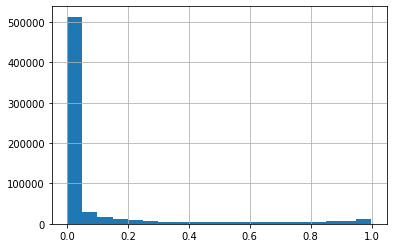

In [28]:
target_df["pred"] = oof_pred
display(target_df["pred"].hist(bins=20))

In [29]:
train = pd.read_csv(CFG["TRAIN_LABEL_CSV"])
if CFG["DEBUG"]:
    train = train.sample(5000).reset_index(drop=True)

train = pd.merge(train, target_df[["contact_id", "pred"]], on="contact_id", how="left")
train = train.fillna(0)
print(len(train))

def func(x_list):
    score = matthews_corrcoef(train['contact'], train["pred"]>x_list[0])
    return -score
x0 = [0.5]
result = minimize(func, x0,  method="nelder-mead")
opt_threshold = result.x[0]
score = round(matthews_corrcoef(train['contact'], train["pred"]>opt_threshold), 5)
threshold = round(opt_threshold, 5)
print(f"score:{score}, threshold:{threshold}")

4721618
score:0.72901, threshold:0.34238


## post proc

In [30]:
train = pd.read_csv(CFG["TRAIN_LABEL_CSV"])
# train = train[train["game_play"].isin(train_game_play)]
print(len(train))

# scoring post process
print(f"score:{score}, threshold:{threshold}")
output_threshold =threshold
best_score = score
best_threshold = threshold
best_window = 1

for window_size in [3, 5, 7, 9, 11, 13]:
    print(f"window size = {window_size}", end=", ")
    proc_sub = post_proc_roll(train, target_df, window_size)
    def func(x_list):
        score = matthews_corrcoef(proc_sub['contact'], proc_sub["proc_pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(proc_sub['contact'], proc_sub["proc_pred"]>opt_threshold), 5)
    threshold = round(opt_threshold, 5)
    print(f"score:{score}, threshold:{threshold}")
    if score > best_score:
        best_score = score
        best_threshold = threshold
        best_window = window_size
print(f"BEST SCORE => window size:{best_window}, score:{best_score}, threshold:{best_threshold} ")

4721618
score:0.72901, threshold:0.34238
window size = 3, score:0.7386, threshold:0.31406
window size = 5, score:0.74029, threshold:0.34004
window size = 7, score:0.74023, threshold:0.33818
window size = 9, score:0.73871, threshold:0.34102
window size = 11, score:0.73648, threshold:0.33555
window size = 13, score:0.73185, threshold:0.33135
BEST SCORE => window size:5, score:0.74029, threshold:0.34004 


In [31]:
print(len(FEATURE_COLS))
print(FEATURE_COLS)
del train

156
['nfl_player_id_1', 'nfl_player_id_2', 'step', 'x_position_1', 'y_position_1', 'speed_1', 'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1', 'team_1', 'jersey_number_1', 'is_lineman_1', 'x_position_shift-6_1', 'x_position_shift-5_1', 'x_position_shift-4_1', 'x_position_shift-3_1', 'x_position_shift-2_1', 'x_position_shift-1_1', 'x_position_shift0_1', 'x_position_shift1_1', 'x_position_shift2_1', 'x_position_shift3_1', 'x_position_shift4_1', 'x_position_shift5_1', 'y_position_shift-6_1', 'y_position_shift-5_1', 'y_position_shift-4_1', 'y_position_shift-3_1', 'y_position_shift-2_1', 'y_position_shift-1_1', 'y_position_shift0_1', 'y_position_shift1_1', 'y_position_shift2_1', 'y_position_shift3_1', 'y_position_shift4_1', 'y_position_shift5_1', 'x_position_2', 'y_position_2', 'speed_2', 'distance_2', 'direction_2', 'orientation_2', 'acceleration_2', 'sa_2', 'team_2', 'jersey_number_2', 'is_lineman_2', 'x_position_shift-6_2', 'x_position_shift-5_2', 'x_position_shift

In [32]:
CFG["features"] = FEATURE_COLS
CFG["PRED_THR"] = output_threshold
CFG["PROC_PRED_THR"] = best_threshold
CFG["proc_window_size"] = best_window

import yaml

cofig_yaml = os.path.join(CFG["EXP_DIR"], "Config.yaml")
with open(cofig_yaml, "w") as f:
    yaml.dump(CFG, f)